<a href="https://colab.research.google.com/github/khykelly-cloud/mul/blob/main/%EB%AC%BC%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

customer = pd.read_csv("Customer.csv")
dc = pd.read_csv("DistributionCenter.csv")
truck = pd.read_csv("Truck.csv")

print(customer.head())
print(dc.head())
print(truck.head())


    X   Y  DEMAND
0  37  52       7
1   9  49      30
2   2  64      16
3   0  26       9
4   0  30      21
    X   Y  CAPACITY  COST
0  30  46     10000    40
1  37  39     10000    40
2  23  43     10000    40
3  56  38     10000    40
4  42  43     10000    40
   CAPACITY
0       160


In [ ]:
import numpy as np
from scipy.spatial.distance import cdist

# 고객 → 센터 거리 행렬 (50 × 5)
distance_dc_customer = cdist(
    customer[['X','Y']],
    dc[['X','Y']],
    metric='euclidean'
)

distance_dc_customer[:5]   # 앞부분만 출력


array([[ 9.21954446, 13.        , 16.64331698, 23.60084744, 10.29563014],
       [21.21320344, 29.73213749, 15.23154621, 48.27007354, 33.54101966],
       [33.28663395, 43.01162634, 29.69848481, 59.93329626, 45.17742799],
       [36.05551275, 39.2173431 , 28.60069929, 57.27128425, 45.31004304],
       [34.        , 38.07886553, 26.41968963, 56.56854249, 43.96589587]])

In [ ]:
customer = pd.read_csv("Customer.csv")
dc = pd.read_csv("DistributionCenter.csv")
truck = pd.read_csv("Truck.csv")

I = range(len(dc))          # 5개 물류센터 후보지
J = range(len(customer))    # 50명 고객


In [ ]:
distance_dc_customer = cdist(
    customer[['X','Y']],
    dc[['X','Y']],
    metric='euclidean'
)


In [ ]:
import pulp


In [ ]:
!pip install ortools


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.7/27.7 MB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.1/321.1 kB 19.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 6.31.1 which is incompatible.
google-ai-generativelanguage 0.6.15 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.

Status: Optimal
열린 DC: [0, 1, 2, 3, 4]

DC별 고객 배정 결과
DC 0: 고객 [0, 25, 26, 30, 47]
DC 1: 고객 [11, 14, 16, 36, 43, 44, 45]
DC 2: 고객 [1, 2, 3, 4, 5, 6, 7, 8, 12, 13, 17, 18, 22, 23, 24, 39, 40, 41, 42, 46]
DC 3: 고객 [9, 15, 19, 20, 28, 29, 32, 33, 34, 35, 38, 48, 49]
DC 4: 고객 [10, 21, 27, 31, 37]


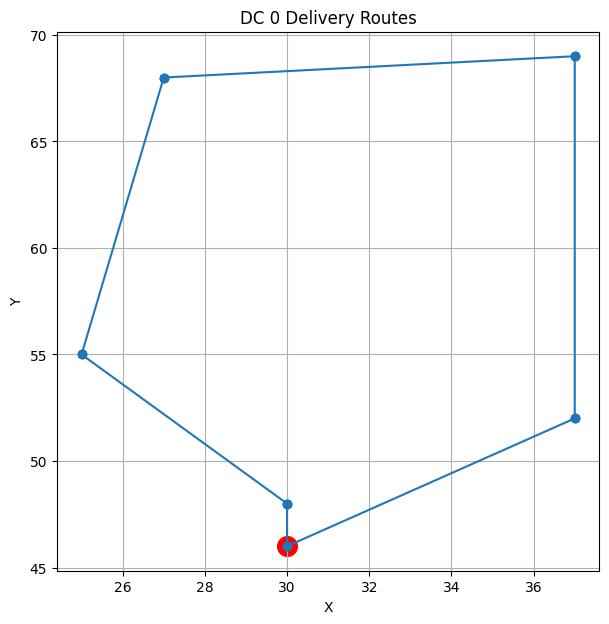

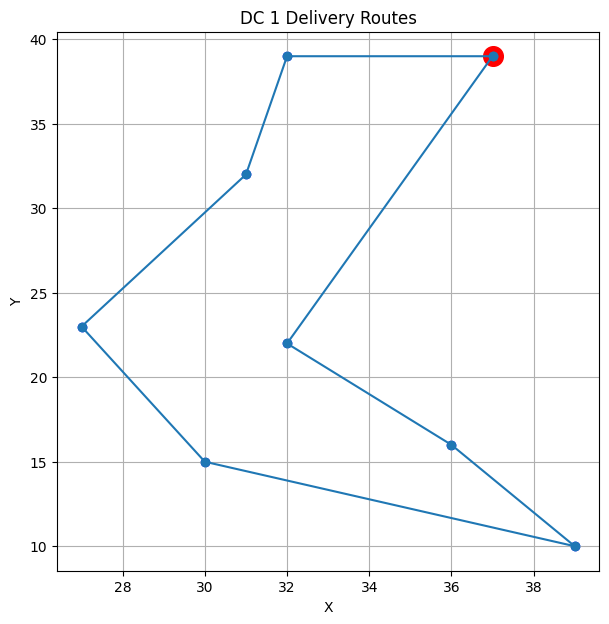

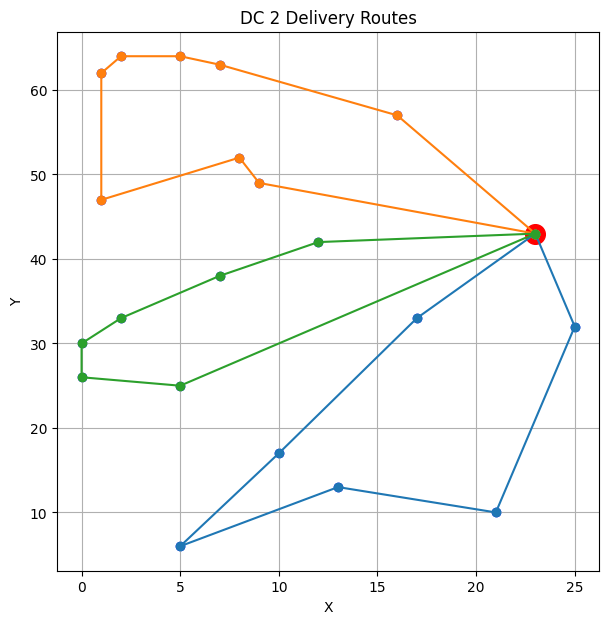

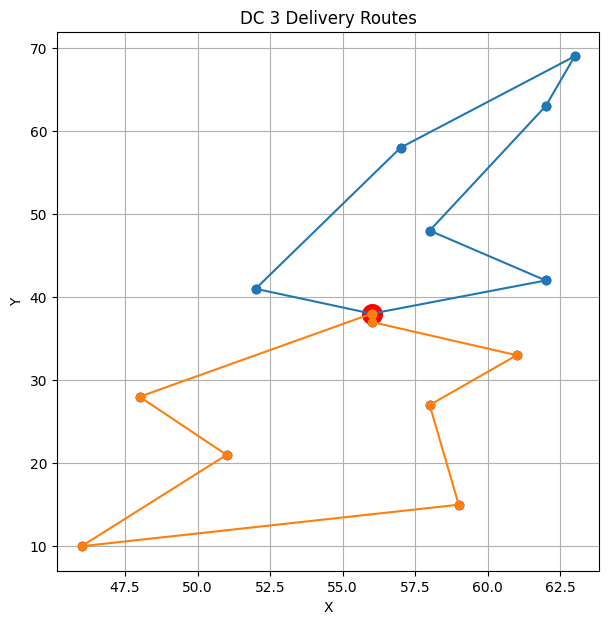

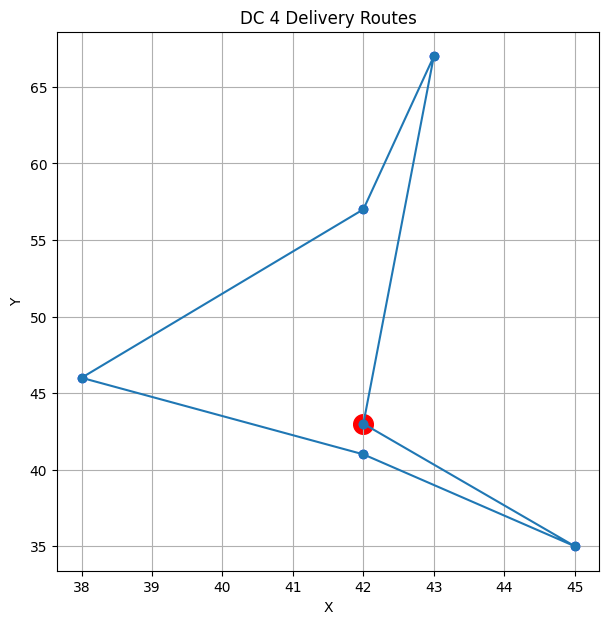

In [ ]:
# =========================================================
# 0. 라이브러리 로드
# =========================================================
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

from ortools.constraint_solver import pywrapcp, routing_enums_pb2
import pulp


# =========================================================
# 1. CSV 불러오기
# =========================================================
customer = pd.read_csv("Customer.csv")
dc = pd.read_csv("DistributionCenter.csv")
truck = pd.read_csv("Truck.csv")

I = range(len(dc))          # DC index
J = range(len(customer))    # Customer index


# =========================================================
# 2. 거리행렬 생성 (고객 → DC)
# =========================================================
distance_dc_customer = cdist(
    customer[['X','Y']],
    dc[['X','Y']],
    metric='euclidean'
)


# =========================================================
# 3. Facility Location Problem (입지선정 MIP)
# =========================================================
model = pulp.LpProblem("FacilityLocation", pulp.LpMinimize)

# 결정변수
y = pulp.LpVariable.dicts("open_dc", I, cat='Binary')
x = pulp.LpVariable.dicts("assign", (I, J), cat='Binary')

# 목적함수 (센터개설비 + 수송비)
facility_cost = pulp.lpSum(dc.loc[i,'COST'] * y[i] for i in I)

transport_cost = pulp.lpSum(
    distance_dc_customer[j,i] * customer.loc[j,'DEMAND'] * x[i][j]
    for i in I for j in J
)

model += facility_cost + transport_cost

# 제약 1: 고객은 하나의 DC에만 할당
for j in J:
    model += pulp.lpSum(x[i][j] for i in I) == 1

# 제약 2: DC 용량 제한
for i in I:
    model += pulp.lpSum(customer.loc[j,'DEMAND'] * x[i][j] for j in J) <= dc.loc[i,'CAPACITY']

# 제약 3: DC 안 열면 배정 불가
for i in I:
    for j in J:
        model += x[i][j] <= y[i]

# 최적화 실행
model.solve(pulp.PULP_CBC_CMD(msg=False))
print("Status:", pulp.LpStatus[model.status])


# =========================================================
# 4. FLP 결과: 개설된 DC + 고객 배정
# =========================================================
open_dcs = [i for i in I if y[i].value() == 1]
print("열린 DC:", open_dcs)

# DC별 고객 리스트
dc_customers = {i: [] for i in open_dcs}

for i in open_dcs:
    for j in J:
        if x[i][j].value() == 1:
            dc_customers[i].append(j)

print("\nDC별 고객 배정 결과")
for i in dc_customers:
    print(f"DC {i}: 고객 {dc_customers[i]}")


# =========================================================
# 5. VRP Solver (OR-Tools)
# =========================================================
def solve_vrp(coords, demands, truck_capacity):
    distance_matrix = cdist(coords, coords, 'euclidean').astype(int)

    num_locations = len(coords)
    num_vehicles = 10    # 충분히 크게
    depot = 0

    manager = pywrapcp.RoutingIndexManager(num_locations, num_vehicles, depot)
    routing = pywrapcp.RoutingModel(manager)

    # 거리 콜백
    def distance_callback(i, j):
        return distance_matrix[manager.IndexToNode(i)][manager.IndexToNode(j)]
    transit_callback = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback)

    # 수요 콜백
    def demand_callback(i):
        return demands[manager.IndexToNode(i)]
    demand_idx = routing.RegisterUnaryTransitCallback(demand_callback)

    routing.AddDimensionWithVehicleCapacity(
        demand_idx,
        0,
        [truck_capacity]*num_vehicles,
        True,
        "Capacity"
    )

    search_params = pywrapcp.DefaultRoutingSearchParameters()
    search_params.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )

    solution = routing.SolveWithParameters(search_params)
    routes = []

    if solution:
        for v in range(num_vehicles):
            idx = routing.Start(v)
            if routing.IsEnd(solution.Value(routing.NextVar(idx))):
                continue

            route = []
            while not routing.IsEnd(idx):
                route.append(manager.IndexToNode(idx))
                idx = solution.Value(routing.NextVar(idx))
            route.append(manager.IndexToNode(idx))  # depot 반환
            routes.append(route)

    return routes


# =========================================================
# 6. 각 DC에 대해 VRP 실행
# =========================================================
vrp_routes = {}

for i in open_dcs:
    assigned = dc_customers[i]

    coords = [(dc.loc[i,'X'], dc.loc[i,'Y'])] + [
        (customer.loc[j,'X'], customer.loc[j,'Y']) for j in assigned
    ]
    demands = [0] + [customer.loc[j,'DEMAND'] for j in assigned]

    vrp_routes[i] = solve_vrp(coords, demands, truck.loc[0,'CAPACITY'])


# =========================================================
# 7. 시각화
# =========================================================
for i in open_dcs:
    plt.figure(figsize=(7,7))
    assigned = dc_customers[i]

    # DC
    plt.scatter(dc.loc[i,'X'], dc.loc[i,'Y'], c='red', s=200, label=f"DC {i}")

    # 고객들
    plt.scatter(customer.loc[assigned,'X'], customer.loc[assigned,'Y'], c='blue')

    # 경로
    coords = [(dc.loc[i,'X'], dc.loc[i,'Y'])] + [
        (customer.loc[j,'X'], customer.loc[j,'Y']) for j in assigned
    ]

    for route in vrp_routes[i]:
        xs = [coords[k][0] for k in route]
        ys = [coords[k][1] for k in route]
        plt.plot(xs, ys, '-o')

    plt.title(f"DC {i} Delivery Routes")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid()
    plt.show()


초기 해 비용: 1264.1164932518761
T=800.00 | 현재비용=2047.59 | 최적비용=1250.50
T=720.00 | 현재비용=2140.29 | 최적비용=1250.50
T=648.00 | 현재비용=2128.38 | 최적비용=1250.50
T=583.20 | 현재비용=2086.42 | 최적비용=1250.50
T=524.88 | 현재비용=2082.29 | 최적비용=1250.50
T=472.39 | 현재비용=2180.21 | 최적비용=1250.50
T=425.15 | 현재비용=2360.91 | 최적비용=1250.50
T=382.64 | 현재비용=2050.96 | 최적비용=1250.50
T=344.37 | 현재비용=2100.40 | 최적비용=1250.50
T=309.94 | 현재비용=2199.98 | 최적비용=1250.50
T=278.94 | 현재비용=2138.39 | 최적비용=1250.50
T=251.05 | 현재비용=2112.20 | 최적비용=1250.50
T=225.94 | 현재비용=2116.47 | 최적비용=1250.50
T=203.35 | 현재비용=2056.46 | 최적비용=1250.50
T=183.01 | 현재비용=2171.86 | 최적비용=1250.50
T=164.71 | 현재비용=1996.41 | 최적비용=1250.50
T=148.24 | 현재비용=2234.57 | 최적비용=1250.50
T=133.42 | 현재비용=2179.63 | 최적비용=1250.50
T=120.08 | 현재비용=1798.50 | 최적비용=1250.50
T=108.07 | 현재비용=2066.77 | 최적비용=1250.50
T=97.26 | 현재비용=1954.64 | 최적비용=1250.50
T=87.54 | 현재비용=2130.15 | 최적비용=1250.50
T=78.78 | 현재비용=1918.32 | 최적비용=1250.50
T=70.90 | 현재비용=1714.63 | 최적비용=1250.50
T=63.81 | 현재비용=1735.30 | 최적비용=1250.50
T=

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51201 (\N{HANGUL SYLLABLE JEOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54644 (\N{HANGUL SYLLABLE HAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


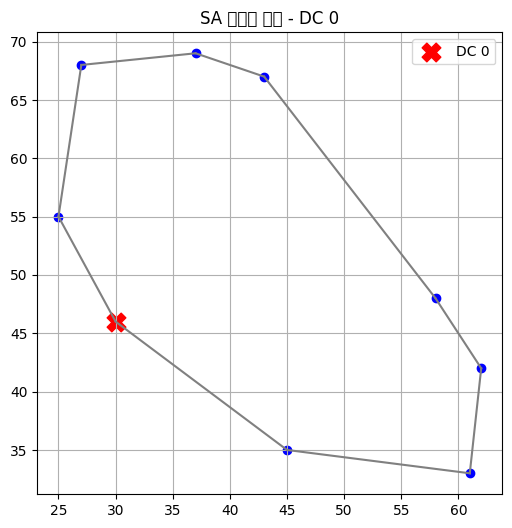

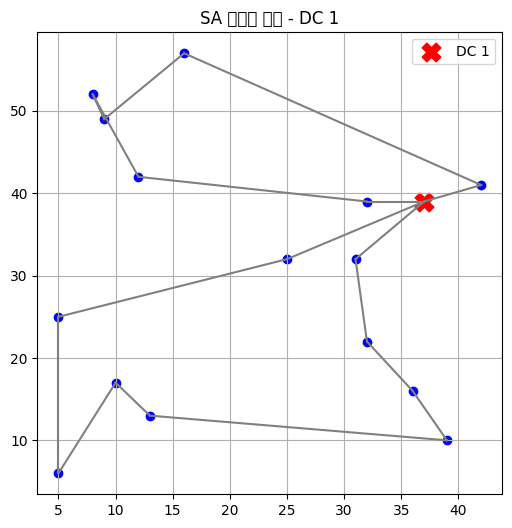

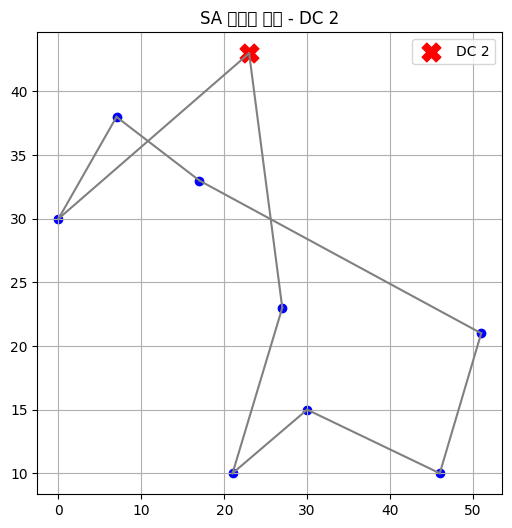

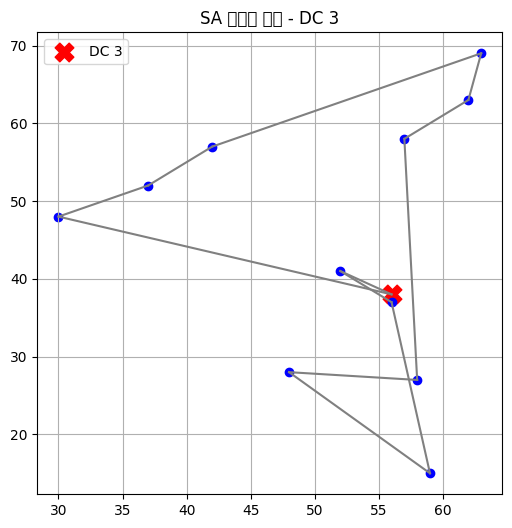

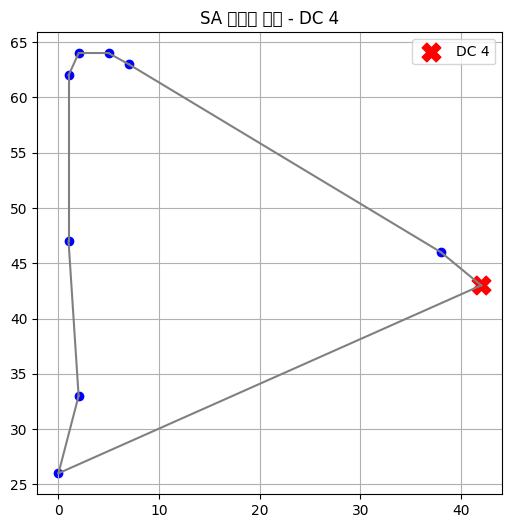

In [38]:
# =========================================================
# Simulated Annealing : 통합 입지선정 + 라우팅 (NO OR-TOOLS)
# =========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# ---------------------------------------------------------
# 1) Data Load
# ---------------------------------------------------------
customer = pd.read_csv("/content/Customer.csv").reset_index().rename(columns={"index":"Customer_ID"})
dc = pd.read_csv("/content/DistributionCenter.csv").reset_index().rename(columns={"index":"DC_ID"})
truck = pd.read_csv("/content/Truck.csv")

C = len(customer)   # number of customers
D = len(dc)         # number of DCs

TRUCK_CAPACITY = int(truck["CAPACITY"].iloc[0])   # 공주님이 말한 160
OPEN_COST = float(dc["COST"].iloc[0])             # DC 하나 개설비

# ---------------------------------------------------------
# 2) 거리 계산 함수 (유클리드)
# ---------------------------------------------------------
def euclid(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

dc_coords = [(dc.loc[j, "X"], dc.loc[j, "Y"]) for j in range(D)]
cust_coords = [(customer.loc[i, "X"], customer.loc[i, "Y"]) for i in range(C)]

# ---------------------------------------------------------
# 3) 한 DC에 대한 라우트 생성 & 거리 계산
#    - 입력: dc_id, 그 DC에 배정된 고객들의 "방문 순서 리스트"
#    - 용량 160을 넘지 않게 순차적으로 route를 끊어가며 생성
# ---------------------------------------------------------
def build_routes_for_dc(dc_id, ordered_customers):
    """
    dc_id : 0~D-1
    ordered_customers : 이 DC에 배정된 고객 index들의 순서 리스트
    return: routes, total_distance
        routes = [[cust_i, cust_j, ...], [...], ...]  # 각 route는 고객 index 리스트
    """
    routes = []
    current_route = []
    current_load = 0

    # customer 수요 가져오기 쉽게
    demand = customer["DEMAND"].values

    for cid in ordered_customers:
        d = demand[cid]
        # 이번 고객을 넣으면 160을 넘는다면 → 지금 route를 종결하고 새 route 시작
        if current_route and current_load + d > TRUCK_CAPACITY:
            routes.append(current_route)
            current_route = [cid]
            current_load = d
        else:
            current_route.append(cid)
            current_load += d

    if current_route:
        routes.append(current_route)

    # 각 route의 거리 계산
    total_dist = 0.0
    depot = dc_coords[dc_id]

    for rt in routes:
        # depot → 첫 고객
        prev = depot
        for cid in rt:
            cur = cust_coords[cid]
            total_dist += euclid(prev, cur)
            prev = cur
        # 마지막 고객 → depot 복귀
        total_dist += euclid(prev, depot)

    return routes, total_dist

# ---------------------------------------------------------
# 4) 해 표현
# ---------------------------------------------------------
# - assign[i] = 고객 i가 배정된 DC id (0~D-1)
# - order[j]  = DC j 안의 고객 방문 순서 리스트 (고객 index들)
#
# 단, order[j]는 assign에 맞춰 항상 유지되도록 갱신할 것.

# 초기해: 각 고객을 "가장 가까운 DC"에 배정하고,
#         DC 내부 순서는 그냥 index 오름차순으로.
def create_initial_solution():
    assign = [0] * C
    order = {j: [] for j in range(D)}

    for i in range(C):
        dists = [euclid(cust_coords[i], dc_coords[j]) for j in range(D)]
        best_dc = int(np.argmin(dists))
        assign[i] = best_dc
        order[best_dc].append(i)

    return assign, order

# ---------------------------------------------------------
# 5) 비용 계산 함수
# ---------------------------------------------------------
def compute_cost(assign, order):
    """
    assign, order를 기반으로
      - 어떤 DC가 열렸는지
      - 각 DC에서 라우트가 어떻게 나오는지(용량 160 기준)
      - 총 거리 + 개설비용
    을 계산
    """
    opened = []
    total_vrp_cost = 0.0
    routes_detail = {}

    for j in range(D):
        # 이 DC에 assign된 고객만 추려서, 그 중 order 순서대로 재구성
        assigned_customers = [i for i in order[j] if assign[i] == j]
        if len(assigned_customers) == 0:
            continue

        opened.append(j)
        routes, dist = build_routes_for_dc(j, assigned_customers)
        total_vrp_cost += dist
        routes_detail[j] = {
            "routes": routes,
            "ordered_customers": assigned_customers,
            "distance": dist
        }

    open_cost = len(opened) * OPEN_COST
    total_cost = open_cost + total_vrp_cost

    info = {
        "opened": opened,
        "open_cost": open_cost,
        "vrp_cost": total_vrp_cost,
        "routes_detail": routes_detail
    }
    return total_cost, info

# ---------------------------------------------------------
# 6) 이웃 해 생성
#    두 가지 move를 섞어서 사용:
#    (A) 고객을 다른 DC로 옮기기 (facility 변경)
#    (B) 같은 DC 안에서 방문 순서 swap
# ---------------------------------------------------------
def generate_neighbor(assign, order, p_move_dc=0.5):
    new_assign = assign[:]
    new_order = {j: lst[:] for j, lst in order.items()}

    if random.random() < p_move_dc:
        # (A) 고객을 다른 DC로 옮기기
        i = random.randint(0, C-1)
        current_dc = new_assign[i]
        cand_dcs = [j for j in range(D) if j != current_dc]
        if not cand_dcs:
            return new_assign, new_order
        new_dc = random.choice(cand_dcs)

        # assign 변경
        new_assign[i] = new_dc

        # old DC 순서 리스트에서 제거
        if i in new_order[current_dc]:
            new_order[current_dc].remove(i)
        # new DC 리스트에 랜덤 위치로 삽입
        pos = random.randint(0, len(new_order[new_dc]))
        new_order[new_dc].insert(pos, i)

    else:
        # (B) 같은 DC 안에서 순서 swap
        # 고객이 2명 이상인 DC 하나 선택
        dcs_with_many = [j for j in range(D) if len(new_order[j]) >= 2]
        if not dcs_with_many:
            return new_assign, new_order
        j = random.choice(dcs_with_many)
        lst = new_order[j]
        a, b = random.sample(range(len(lst)), 2)
        lst[a], lst[b] = lst[b], lst[a]
        new_order[j] = lst

    return new_assign, new_order

# ---------------------------------------------------------
# 7) Simulated Annealing 메인 루프
# ---------------------------------------------------------
def simulated_annealing(
    T_init=1000.0,
    T_min=1.0,
    alpha=0.95,
    iter_per_T=50,
    verbose=True
):
    assign, order = create_initial_solution()
    current_cost, current_info = compute_cost(assign, order)

    best_assign = assign[:]
    best_order = {j: lst[:] for j, lst in order.items()}
    best_cost = current_cost
    best_info = current_info

    T = T_init
    it = 0

    if verbose:
        print("초기 해 비용:", current_cost)

    while T > T_min:
        for _ in range(iter_per_T):
            it += 1
            neigh_assign, neigh_order = generate_neighbor(assign, order)
            neigh_cost, neigh_info = compute_cost(neigh_assign, neigh_order)

            delta = neigh_cost - current_cost

            if delta < 0:
                accept = True
            else:
                prob = np.exp(-delta / T)
                accept = (random.random() < prob)

            if accept:
                assign, order = neigh_assign, neigh_order
                current_cost, current_info = neigh_cost, neigh_info

                if current_cost < best_cost:
                    best_assign = assign[:]
                    best_order = {j: lst[:] for j, lst in order.items()}
                    best_cost = current_cost
                    best_info = current_info

        if verbose:
            print(f"T={T:.2f} | 현재비용={current_cost:.2f} | 최적비용={best_cost:.2f}")

        T *= alpha

    return best_assign, best_order, best_cost, best_info

# ---------------------------------------------------------
# 8) SA 실행
# ---------------------------------------------------------
random.seed(0)
np.random.seed(0)

best_assign, best_order, best_cost, best_info = simulated_annealing(
    T_init=800.0,
    T_min=1.0,
    alpha=0.90,
    iter_per_T=80,
    verbose=True
)

print("\n========== SA 최종 결과 ==========")
print("최적 비용:", best_cost)
print("개설된 DC:", best_info["opened"])
print("개설비용:", best_info["open_cost"])
print("VRP 비용:", best_info["vrp_cost"])
print("==================================")

# ---------------------------------------------------------
# 9) 최적 해 시각화
# ---------------------------------------------------------
for dc_id in best_info["opened"]:
    detail = best_info["routes_detail"][dc_id]
    routes = detail["routes"]

    depot_x, depot_y = dc_coords[dc_id]

    plt.figure(figsize=(6,6))
    # depot
    plt.scatter(depot_x, depot_y, c="red", marker="X", s=180, label=f"DC {dc_id}")

    # 고객
    for rt in routes:
        for cid in rt:
            x, y = cust_coords[cid]
            plt.scatter(x, y, c="blue")

    # route 그리기
    for rt in routes:
        prev = (depot_x, depot_y)
        for cid in rt:
            cur = cust_coords[cid]
            plt.plot([prev[0], cur[0]], [prev[1], cur[1]], c="gray")
            prev = cur
        # 마지막 고객 → depot
        plt.plot([prev[0], depot_x], [prev[1], depot_y], c="gray")

    plt.title(f"SA 최적해 경로 - DC {dc_id}")
    plt.grid()
    plt.legend()
    plt.show()


In [32]:
# =========================================================
# CASE 1 : SA + Workload Balancing (λ 제약, NO OR-TOOLS)
# =========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# ---------------------------------------------------------
# 1) 데이터 로드
# ---------------------------------------------------------
customer = pd.read_csv("/content/Customer.csv").reset_index().rename(columns={"index":"Customer_ID"})
dc = pd.read_csv("/content/DistributionCenter.csv").reset_index().rename(columns={"index":"DC_ID"})
truck = pd.read_csv("/content/Truck.csv")

C = len(customer)   # 고객 수
D = len(dc)         # DC 수

TRUCK_CAPACITY = int(truck["CAPACITY"].iloc[0])   # 160
OPEN_COST = float(dc["COST"].iloc[0])             # DC 개설비 (동일하다고 가정)

demand = customer["DEMAND"].values
total_demand = demand.sum()

dc_coords = [(dc.loc[j, "X"], dc.loc[j, "Y"]) for j in range(D)]
cust_coords = [(customer.loc[i, "X"], customer.loc[i, "Y"]) for i in range(C)]

# ---------------------------------------------------------
# 2) 거리 함수
# ---------------------------------------------------------
def euclid(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

# ---------------------------------------------------------
# 3) 한 DC에 대해 route 생성 (용량 160 반영) + 거리 계산
# ---------------------------------------------------------
def build_routes_for_dc(dc_id, ordered_customers):
    routes = []
    current_route = []
    current_load = 0

    for cid in ordered_customers:
        d = demand[cid]
        if current_route and current_load + d > TRUCK_CAPACITY:
            routes.append(current_route)
            current_route = [cid]
            current_load = d
        else:
            current_route.append(cid)
            current_load += d

    if current_route:
        routes.append(current_route)

    depot = dc_coords[dc_id]
    total_dist = 0.0

    for rt in routes:
        prev = depot
        for cid in rt:
            cur = cust_coords[cid]
            total_dist += euclid(prev, cur)
            prev = cur
        total_dist += euclid(prev, depot)

    return routes, total_dist

# ---------------------------------------------------------
# 4) CASE 1: λ-균형 제약용 feasibility check
#    sum_i demand_i x_ij <= λ * TotalDemand
# ---------------------------------------------------------
def is_feasible_balance(assign, lam):
    dc_dem = np.zeros(D)
    for i in range(C):
        j = assign[i]
        dc_dem[j] += demand[i]
    limit = lam * total_demand
    for j in range(D):
        if dc_dem[j] > limit:
            return False
    return True

# ---------------------------------------------------------
# 5) 초기 해 생성 (가장 가까운 DC로 배정 + 제약 위반 시 간단 수정)
# ---------------------------------------------------------
def create_initial_solution_balance(lam, max_iter=10000):
    # 1차: 가장 가까운 DC로 배정
    assign = [0] * C
    for i in range(C):
        dists = [euclid(cust_coords[i], dc_coords[j]) for j in range(D)]
        assign[i] = int(np.argmin(dists))

    # 간단 repair: λ 제약 만족할 때까지 과부하 DC에서 고객을 다른 DC로 이동
    it = 0
    while not is_feasible_balance(assign, lam) and it < max_iter:
        it += 1
        dc_dem = np.zeros(D)
        for i in range(C):
            dc_dem[assign[i]] += demand[i]

        limit = lam * total_demand
        bad_list = [j for j in range(D) if dc_dem[j] > limit]
        if not bad_list:
            break

        j_bad = random.choice(bad_list)
        # 이 DC에 배정된 고객들 중 하나를 다른 DC로 이동
        cand_customers = [i for i in range(C) if assign[i] == j_bad]
        if not cand_customers:
            break
        i_move = random.choice(cand_customers)

        # 다른 DC들 중 하나 선택 (간단히 랜덤)
        other_dcs = [j for j in range(D) if j != j_bad]
        if not other_dcs:
            break
        j_new = random.choice(other_dcs)
        assign[i_move] = j_new

    # order[j]는 assign 순서대로
    order = {j: [] for j in range(D)}
    for i in range(C):
        order[assign[i]].append(i)

    return assign, order

# ---------------------------------------------------------
# 6) 비용 계산
# ---------------------------------------------------------
def compute_cost_balance(assign, order, lam):
    # 제약 위반이면 매우 큰 값 (실질적으로 배제)
    if not is_feasible_balance(assign, lam):
        return 1e18, {"feasible": False}

    opened = []
    total_vrp_cost = 0.0
    routes_detail = {}

    for j in range(D):
        assigned_customers = [i for i in order[j] if assign[i] == j]
        if len(assigned_customers) == 0:
            continue

        opened.append(j)
        routes, dist = build_routes_for_dc(j, assigned_customers)
        total_vrp_cost += dist
        routes_detail[j] = {
            "routes": routes,
            "ordered_customers": assigned_customers,
            "distance": dist
        }

    open_cost = len(opened) * OPEN_COST
    total_cost = open_cost + total_vrp_cost

    info = {
        "feasible": True,
        "opened": opened,
        "open_cost": open_cost,
        "vrp_cost": total_vrp_cost,
        "routes_detail": routes_detail
    }
    return total_cost, info

# ---------------------------------------------------------
# 7) 이웃 해 생성 (DC 변경 or 순서 swap)
# ---------------------------------------------------------
def generate_neighbor(assign, order, p_move_dc=0.5):
    new_assign = assign[:]
    new_order = {j: lst[:] for j, lst in order.items()}

    if random.random() < p_move_dc:
        # 고객을 다른 DC로 옮기기
        i = random.randint(0, C-1)
        cur_dc = new_assign[i]
        cand = [j for j in range(D) if j != cur_dc]
        if not cand:
            return new_assign, new_order
        new_dc = random.choice(cand)
        new_assign[i] = new_dc

        # order 수정
        if i in new_order[cur_dc]:
            new_order[cur_dc].remove(i)
        pos = random.randint(0, len(new_order[new_dc]))
        new_order[new_dc].insert(pos, i)
    else:
        # 같은 DC 안에서 방문 순서 swap
        dcs_with_many = [j for j in range(D) if len(new_order[j]) >= 2]
        if not dcs_with_many:
            return new_assign, new_order
        j = random.choice(dcs_with_many)
        lst = new_order[j]
        a, b = random.sample(range(len(lst)), 2)
        lst[a], lst[b] = lst[b], lst[a]
        new_order[j] = lst

    return new_assign, new_order

# ---------------------------------------------------------
# 8) SA 메인 루프
# ---------------------------------------------------------
def simulated_annealing_balance(
    lam,
    T_init=1000.0,
    T_min=1.0,
    alpha=0.95,
    iter_per_T=60,
    verbose=True
):
    assign, order = create_initial_solution_balance(lam)
    current_cost, current_info = compute_cost_balance(assign, order, lam)

    best_assign = assign[:]
    best_order = {j: lst[:] for j, lst in order.items()}
    best_cost = current_cost
    best_info = current_info

    T = T_init
    if verbose:
        print(f"[λ={lam}] 초기 해 비용:", current_cost)

    while T > T_min:
        for _ in range(iter_per_T):
            neigh_assign, neigh_order = generate_neighbor(assign, order)
            neigh_cost, neigh_info = compute_cost_balance(neigh_assign, neigh_order, lam)

            delta = neigh_cost - current_cost
            if delta < 0:
                accept = True
            else:
                prob = np.exp(-delta / T)
                accept = (random.random() < prob)

            if accept:
                assign, order = neigh_assign, neigh_order
                current_cost, current_info = neigh_cost, neigh_info

                if current_cost < best_cost:
                    best_assign = assign[:]
                    best_order = {j: lst[:] for j, lst in order.items()}
                    best_cost = current_cost
                    best_info = current_info

        if verbose:
            print(f"T={T:.2f} | 현재비용={current_cost:.2f} | 최적비용={best_cost:.2f}")
        T *= alpha

    return best_assign, best_order, best_cost, best_info

# ---------------------------------------------------------
# 9) λ 하나에 대해 실행 + 시각화
# ---------------------------------------------------------
def run_for_lambda(lam):
    random.seed(0)
    np.random.seed(0)

    best_assign, best_order, best_cost, best_info = simulated_annealing_balance(lam, T_init=800.0, T_min=1.0, alpha=0.9)

    print("\n========== SA + 균형제약 결과 (λ =", lam, ") ==========")
    print("최적 비용:", best_cost)
    print("개설된 DC:", best_info["opened"])
    print("개설비용:", best_info["open_cost"])
    print("VRP 비용:", best_info["vrp_cost"])

    # 시각화
    for dc_id in best_info["opened"]:
        detail = best_info["routes_detail"][dc_id]
        routes = detail["routes"]

        depot_x, depot_y = dc_coords[dc_id]
        plt.figure(figsize=(6,6))
        plt.scatter(depot_x, depot_y, c="red", marker="X", s=180, label=f"DC {dc_id}")

        for rt in routes:
            for cid in rt:
                x, y = cust_coords[cid]
                plt.scatter(x, y, c="blue")

        for rt in routes:
            prev = (depot_x, depot_y)
            for cid in rt:
                cur = cust_coords[cid]
                plt.plot([prev[0], cur[0]], [prev[1], cur[1]], c="gray")
                prev = cur
            plt.plot([prev[0], depot_x], [prev[1], depot_y], c="gray")

        plt.title(f"SA + Balance (λ={lam}) - DC {dc_id}")
        plt.grid()
        plt.legend()
        plt.show()

    return best_cost, best_info

# 예시 실행
# cost, info = run_for_lambda(0.49)


In [33]:
# ==========================================
# CASE 1 : λ 후보들 중 최적 λ 찾기 (SA 기반)
# ==========================================

def search_best_lambda(
    lambda_list,
    n_restarts=3,          # 각 λ마다 SA를 몇 번 돌릴지
    T_init=800.0,
    T_min=1.0,
    alpha=0.9,
    iter_per_T=80
):
    results = []

    for lam in lambda_list:
        best_cost_lam = float("inf")
        best_info_lam = None

        for r in range(n_restarts):
            # 매번 다른 초기해를 위해 seed를 조금씩 바꿔줌
            random.seed(1000 + r)
            np.random.seed(2000 + r)

            _, _, cost, info = simulated_annealing_balance(
                lam=lam,
                T_init=T_init,
                T_min=T_min,
                alpha=alpha,
                iter_per_T=iter_per_T,
                verbose=False,   # 로그 너무 많이 나오면 False
            )

            if cost < best_cost_lam:
                best_cost_lam = cost
                best_info_lam = info

        print(f"λ={lam:.3f} | best cost={best_cost_lam:.2f} | opened={best_info_lam['opened']}")
        results.append((lam, best_cost_lam, best_info_lam))

    # 전체 λ 중 최적 선택
    results.sort(key=lambda x: x[1])
    best_lambda, best_cost, best_info = results[0]

    print("\n===== λ 탐색 결과 =====")
    print("최적 λ:", best_lambda)
    print("최소 총비용:", best_cost)
    print("개설된 DC:", best_info["opened"])
    print("=======================")

    return best_lambda, best_cost, best_info, results


# 예시 사용
lambda_candidates = [0.40, 0.45, 0.49, 0.50, 0.60]

best_lambda, best_cost, best_info, all_results = search_best_lambda(
    lambda_list=lambda_candidates,
    n_restarts=5,       # 더 많이 돌릴수록 global optimum에 가까워짐
    T_init=800,
    T_min=1.0,
    alpha=0.90,
    iter_per_T=80,
)


λ=0.400 | best cost=950.45 | opened=[0, 1, 2, 3, 4]
λ=0.450 | best cost=819.22 | opened=[0, 1, 2, 3, 4]
λ=0.490 | best cost=982.92 | opened=[0, 1, 2, 3, 4]
λ=0.500 | best cost=964.68 | opened=[0, 1, 2, 3, 4]
λ=0.600 | best cost=964.68 | opened=[0, 1, 2, 3, 4]

===== λ 탐색 결과 =====
최적 λ: 0.45
최소 총비용: 819.2190898423012
개설된 DC: [0, 1, 2, 3, 4]


In [35]:
# =========================================================
# CASE 2 : SA + Minimum Customers (MIN_CUST 제약, NO OR-TOOLS)
# =========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# ---------------------------------------------------------
# 1) 데이터 로드
# ---------------------------------------------------------
customer = pd.read_csv("/content/Customer.csv").reset_index().rename(columns={"index":"Customer_ID"})
dc = pd.read_csv("/content/DistributionCenter.csv").reset_index().rename(columns={"index":"DC_ID"})
truck = pd.read_csv("/content/Truck.csv")

C = len(customer)
D = len(dc)

TRUCK_CAPACITY = int(truck["CAPACITY"].iloc[0])   # 160
OPEN_COST = float(dc["COST"].iloc[0])

demand = customer["DEMAND"].values
dc_coords = [(dc.loc[j, "X"], dc.loc[j, "Y"]) for j in range(D)]
cust_coords = [(customer.loc[i, "X"], customer.loc[i, "Y"]) for i in range(C)]

def euclid(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

def build_routes_for_dc(dc_id, ordered_customers):
    routes = []
    current_route = []
    current_load = 0

    for cid in ordered_customers:
        d = demand[cid]
        if current_route and current_load + d > TRUCK_CAPACITY:
            routes.append(current_route)
            current_route = [cid]
            current_load = d
        else:
            current_route.append(cid)
            current_load += d

    if current_route:
        routes.append(current_route)

    depot = dc_coords[dc_id]
    total_dist = 0.0
    for rt in routes:
        prev = depot
        for cid in rt:
            cur = cust_coords[cid]
            total_dist += euclid(prev, cur)
            prev = cur
        total_dist += euclid(prev, depot)
    return routes, total_dist

# ---------------------------------------------------------
# CASE 2 : MIN_CUST 제약용 feasibility
#   열린 DC는 0 또는 >= MIN_CUST 고객
# ---------------------------------------------------------
def is_feasible_mincust(assign, min_cust):
    counts = np.zeros(D, dtype=int)
    for i in range(C):
        counts[assign[i]] += 1

    for j in range(D):
        if 0 < counts[j] < min_cust:
            return False
    return True

# ---------------------------------------------------------
# 초기 해 생성 (가까운 DC + under-utilized DC 비우기)
# ---------------------------------------------------------
def create_initial_solution_mincust(min_cust, max_iter=10000):
    assign = [0] * C
    for i in range(C):
        dists = [euclid(cust_coords[i], dc_coords[j]) for j in range(D)]
        assign[i] = int(np.argmin(dists))

    it = 0
    while not is_feasible_mincust(assign, min_cust) and it < max_iter:
        it += 1
        counts = np.zeros(D, dtype=int)
        for i in range(C):
            counts[assign[i]] += 1

        bad_dcs = [j for j in range(D) if 0 < counts[j] < min_cust]
        if not bad_dcs:
            break

        j_bad = random.choice(bad_dcs)
        # 이 DC의 고객들을 다른 DC로 이동시켜서 "닫기"
        bad_customers = [i for i in range(C) if assign[i] == j_bad]
        for i_move in bad_customers:
            other_dcs = [j for j in range(D) if j != j_bad]
            assign[i_move] = random.choice(other_dcs)

    order = {j: [] for j in range(D)}
    for i in range(C):
        order[assign[i]].append(i)

    return assign, order

# ---------------------------------------------------------
# 비용 계산 (제약 위반 시 매우 큰 값)
# ---------------------------------------------------------
def compute_cost_mincust(assign, order, min_cust):
    if not is_feasible_mincust(assign, min_cust):
        return 1e18, {"feasible": False}

    opened = []
    total_vrp_cost = 0.0
    routes_detail = {}

    for j in range(D):
        assigned_customers = [i for i in order[j] if assign[i] == j]
        if len(assigned_customers) == 0:
            continue

        opened.append(j)
        routes, dist = build_routes_for_dc(j, assigned_customers)
        total_vrp_cost += dist
        routes_detail[j] = {
            "routes": routes,
            "ordered_customers": assigned_customers,
            "distance": dist
        }

    open_cost = len(opened) * OPEN_COST
    total_cost = open_cost + total_vrp_cost

    info = {
        "feasible": True,
        "opened": opened,
        "open_cost": open_cost,
        "vrp_cost": total_vrp_cost,
        "routes_detail": routes_detail
    }
    return total_cost, info

def generate_neighbor(assign, order, p_move_dc=0.5):
    new_assign = assign[:]
    new_order = {j: lst[:] for j, lst in order.items()}

    if random.random() < p_move_dc:
        i = random.randint(0, C-1)
        cur_dc = new_assign[i]
        cand = [j for j in range(D) if j != cur_dc]
        if not cand:
            return new_assign, new_order
        new_dc = random.choice(cand)
        new_assign[i] = new_dc
        if i in new_order[cur_dc]:
            new_order[cur_dc].remove(i)
        pos = random.randint(0, len(new_order[new_dc]))
        new_order[new_dc].insert(pos, i)
    else:
        dcs_with_many = [j for j in range(D) if len(new_order[j]) >= 2]
        if not dcs_with_many:
            return new_assign, new_order
        j = random.choice(dcs_with_many)
        lst = new_order[j]
        a, b = random.sample(range(len(lst)), 2)
        lst[a], lst[b] = lst[b], lst[a]
        new_order[j] = lst

    return new_assign, new_order

# ---------------------------------------------------------
# SA 메인 루프
# ---------------------------------------------------------
def simulated_annealing_mincust(
    min_cust,
    T_init=1000.0,
    T_min=1.0,
    alpha=0.95,
    iter_per_T=60,
    verbose=True
):
    assign, order = create_initial_solution_mincust(min_cust)
    current_cost, current_info = compute_cost_mincust(assign, order, min_cust)

    best_assign = assign[:]
    best_order = {j: lst[:] for j, lst in order.items()}
    best_cost = current_cost
    best_info = current_info

    T = T_init
    if verbose:
        print(f"[MIN_CUST={min_cust}] 초기 해 비용:", current_cost)

    while T > T_min:
        for _ in range(iter_per_T):
            neigh_assign, neigh_order = generate_neighbor(assign, order)
            neigh_cost, neigh_info = compute_cost_mincust(neigh_assign, neigh_order, min_cust)

            delta = neigh_cost - current_cost
            if delta < 0:
                accept = True
            else:
                prob = np.exp(-delta / T)
                accept = (random.random() < prob)

            if accept:
                assign, order = neigh_assign, neigh_order
                current_cost, current_info = neigh_cost, neigh_info

                if current_cost < best_cost:
                    best_assign = assign[:]
                    best_order = {j: lst[:] for j, lst in order.items()}
                    best_cost = current_cost
                    best_info = current_info

        if verbose:
            print(f"T={T:.2f} | 현재비용={current_cost:.2f} | 최적비용={best_cost:.2f}")
        T *= alpha

    return best_assign, best_order, best_cost, best_info

# ---------------------------------------------------------
# MIN_CUST 하나에 대해 실행 + 시각화
# ---------------------------------------------------------
def run_for_mincust(min_cust):
    random.seed(0)
    np.random.seed(0)

    best_assign, best_order, best_cost, best_info = simulated_annealing_mincust(min_cust, T_init=800.0, T_min=1.0, alpha=0.9)

    print("\n========== SA + 최소수요제약 결과 (MIN_CUST =", min_cust, ") ==========")
    print("최적 비용:", best_cost)
    print("개설된 DC:", best_info["opened"])
    print("개설비용:", best_info["open_cost"])
    print("VRP 비용:", best_info["vrp_cost"])

    for dc_id in best_info["opened"]:
        detail = best_info["routes_detail"][dc_id]
        routes = detail["routes"]

        depot_x, depot_y = dc_coords[dc_id]
        plt.figure(figsize=(6,6))
        plt.scatter(depot_x, depot_y, c="red", marker="X", s=180, label=f"DC {dc_id}")

        for rt in routes:
            for cid in rt:
                x, y = cust_coords[cid]
                plt.scatter(x, y, c="blue")

        for rt in routes:
            prev = (depot_x, depot_y)
            for cid in rt:
                cur = cust_coords[cid]
                plt.plot([prev[0], cur[0]], [prev[1], cur[1]], c="gray")
                prev = cur
            plt.plot([prev[0], depot_x], [prev[1], depot_y], c="gray")

        plt.title(f"SA + MIN_CUST={min_cust} - DC {dc_id}")
        plt.grid()
        plt.legend()
        plt.show()

    return best_cost, best_info

# 예시:
# cost, info = run_for_mincust(20)


In [36]:
# ==========================================
# CASE 2 : MIN_CUST 후보들 중 최적 MIN_CUST 찾기
# ==========================================

def search_best_mincust(
    mincust_list,
    n_restarts=3,
    T_init=800.0,
    T_min=1.0,
    alpha=0.9,
    iter_per_T=80
):
    results = []

    for m in mincust_list:
        best_cost_m = float("inf")
        best_info_m = None

        for r in range(n_restarts):
            random.seed(3000 + r)
            np.random.seed(4000 + r)

            _, _, cost, info = simulated_annealing_mincust(
                min_cust=m,
                T_init=T_init,
                T_min=T_min,
                alpha=alpha,
                iter_per_T=iter_per_T,
                verbose=False,
            )

            if cost < best_cost_m:
                best_cost_m = cost
                best_info_m = info

        print(f"MIN_CUST={m} | best cost={best_cost_m:.2f} | opened={best_info_m['opened']}")
        results.append((m, best_cost_m, best_info_m))

    results.sort(key=lambda x: x[1])
    best_m, best_cost, best_info = results[0]

    print("\n===== MIN_CUST 탐색 결과 =====")
    print("최적 MIN_CUST:", best_m)
    print("최소 총비용:", best_cost)
    print("개설된 DC:", best_info["opened"])
    print("=============================")

    return best_m, best_cost, best_info, results


# 예시 사용
mincust_candidates = [5, 10, 15, 20, 25]

best_m, best_cost, best_info, all_results_m = search_best_mincust(
    mincust_list=mincust_candidates,
    n_restarts=5,
    T_init=800,
    T_min=1.0,
    alpha=0.90,
    iter_per_T=80,
)


MIN_CUST=5 | best cost=914.66 | opened=[0, 1, 2, 3, 4]
MIN_CUST=10 | best cost=918.23 | opened=[2, 3]
MIN_CUST=15 | best cost=927.52 | opened=[2, 3]
MIN_CUST=20 | best cost=985.36 | opened=[2]
MIN_CUST=25 | best cost=912.41 | opened=[4]

===== MIN_CUST 탐색 결과 =====
최적 MIN_CUST: 25
최소 총비용: 912.4063188018054
개설된 DC: [4]


λ=0.400, MIN_CUST=10 | best cost=901.33 | opened=[0, 2, 3]
λ=0.400, MIN_CUST=15 | best cost=895.95 | opened=[0, 1, 2]
λ=0.400, MIN_CUST=20 | infeasible
λ=0.400, MIN_CUST=25 | infeasible
λ=0.450, MIN_CUST=10 | best cost=973.01 | opened=[2, 3, 4]
λ=0.450, MIN_CUST=15 | infeasible
λ=0.450, MIN_CUST=20 | infeasible
λ=0.450, MIN_CUST=25 | infeasible
λ=0.490, MIN_CUST=10 | best cost=951.87 | opened=[2, 3, 4]
λ=0.490, MIN_CUST=15 | infeasible
λ=0.490, MIN_CUST=20 | infeasible
λ=0.490, MIN_CUST=25 | infeasible
λ=0.500, MIN_CUST=10 | best cost=952.92 | opened=[2, 3, 4]
λ=0.500, MIN_CUST=15 | infeasible
λ=0.500, MIN_CUST=20 | infeasible
λ=0.500, MIN_CUST=25 | infeasible
λ=0.600, MIN_CUST=10 | best cost=878.19 | opened=[2, 3]
λ=0.600, MIN_CUST=15 | best cost=1022.55 | opened=[2, 3]
λ=0.600, MIN_CUST=20 | best cost=866.64 | opened=[2, 4]
λ=0.600, MIN_CUST=25 | infeasible

===== (λ, MIN_CUST) 결합 탐색 결과 =====
최적 λ: 0.6
최적 MIN_CUST: 20
최소 총비용: 866.6426376918389
개설된 DC: [2, 4]

[최종 선택] λ = 0.6 , MIN_CU

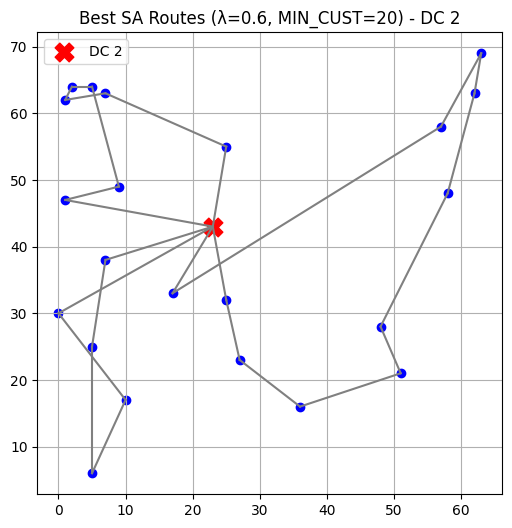

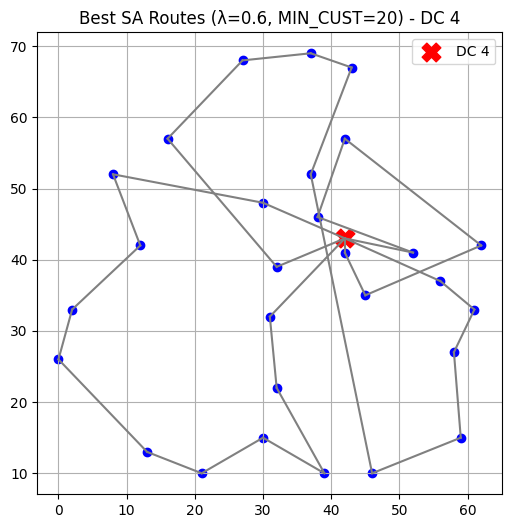

In [39]:
# =========================================================
# SA : 입지 + 경로 + (균형제약 + 최소고객제약) 통합 모델
#  - OR-Tools, MILP 없음 / 전부 SA
# =========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# ---------------------------------------------------------
# 1) 데이터 로드
# ---------------------------------------------------------
customer = pd.read_csv("/content/Customer.csv").reset_index().rename(columns={"index": "Customer_ID"})
dc       = pd.read_csv("/content/DistributionCenter.csv").reset_index().rename(columns={"index": "DC_ID"})
truck    = pd.read_csv("/content/Truck.csv")

C = len(customer)   # 고객 수
D = len(dc)         # DC 수

TRUCK_CAPACITY = int(truck["CAPACITY"].iloc[0])   # 160
OPEN_COST      = float(dc["COST"].iloc[0])        # DC 하나 개설비 (동일하다고 가정)

demand        = customer["DEMAND"].values
total_demand  = demand.sum()

dc_coords   = [(dc.loc[j, "X"], dc.loc[j, "Y"]) for j in range(D)]
cust_coords = [(customer.loc[i, "X"], customer.loc[i, "Y"]) for i in range(C)]

# ---------------------------------------------------------
# 2) 거리 함수
# ---------------------------------------------------------
def euclid(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

# ---------------------------------------------------------
# 3) 한 DC에 대한 route 생성 + 거리 계산
#    - 고객 순서(order[j])를 따라가면서
#      트럭 용량 160 넘으면 새 route 시작
# ---------------------------------------------------------
def build_routes_for_dc(dc_id, ordered_customers):
    routes = []
    current_route = []
    current_load  = 0

    for cid in ordered_customers:
        d = demand[cid]
        if current_route and current_load + d > TRUCK_CAPACITY:
            routes.append(current_route)
            current_route = [cid]
            current_load  = d
        else:
            current_route.append(cid)
            current_load += d

    if current_route:
        routes.append(current_route)

    depot      = dc_coords[dc_id]
    total_dist = 0.0

    for rt in routes:
        prev = depot
        for cid in rt:
            cur = cust_coords[cid]
            total_dist += euclid(prev, cur)
            prev = cur
        total_dist += euclid(prev, depot)

    return routes, total_dist

# ---------------------------------------------------------
# 4) 결합 제약 (CASE1 + CASE2)
#    - 균형제약: sum_i demand_i x_ij <= λ * TotalDemand
#    - 최소고객: 열린 DC는 고객 수가 0 또는 >= MIN_CUST
# ---------------------------------------------------------
def is_feasible_combined(assign, lam, min_cust):
    dc_demands = np.zeros(D)
    counts     = np.zeros(D, dtype=int)

    for i in range(C):
        j = assign[i]
        dc_demands[j] += demand[i]
        counts[j]     += 1

    # 균형 제약
    limit = lam * total_demand
    for j in range(D):
        if dc_demands[j] > limit:
            return False

    # 최소고객 제약 (0 또는 >= MIN_CUST)
    for j in range(D):
        if 0 < counts[j] < min_cust:
            return False

    return True

# ---------------------------------------------------------
# 5) 초기 해 생성 + 간단 repair
#    (가장 가까운 DC로 보낸 뒤, 제약을 만족하도록 조금씩 이동)
# ---------------------------------------------------------
def create_initial_solution_combined(lam, min_cust, max_iter=10000):
    # 1차: 가장 가까운 DC로 배정
    assign = [0] * C
    for i in range(C):
        dists = [euclid(cust_coords[i], dc_coords[j]) for j in range(D)]
        assign[i] = int(np.argmin(dists))

    it = 0
    while not is_feasible_combined(assign, lam, min_cust) and it < max_iter:
        it += 1
        dc_demands = np.zeros(D)
        counts     = np.zeros(D, dtype=int)
        for i in range(C):
            j = assign[i]
            dc_demands[j] += demand[i]
            counts[j]     += 1

        limit  = lam * total_demand
        bad_dc = None
        mode   = None

        # 1) 균형 제약 위반 DC 먼저 처리
        over_list = [j for j in range(D) if dc_demands[j] > limit]
        if over_list:
            bad_dc = random.choice(over_list)
            mode   = "overload"
        else:
            # 2) 최소고객 위반 DC 처리 (0 < count < min_cust)
            small_list = [j for j in range(D) if 0 < counts[j] < min_cust]
            if small_list:
                bad_dc = random.choice(small_list)
                mode   = "small"
            else:
                break

        if mode == "overload":
            # 이 DC의 고객 중 하나를 다른 DC로 이동
            cand_customers = [i for i in range(C) if assign[i] == bad_dc]
            if not cand_customers:
                break
            i_move = random.choice(cand_customers)
            other_dcs = [j for j in range(D) if j != bad_dc]
            if not other_dcs:
                break
            assign[i_move] = random.choice(other_dcs)

        elif mode == "small":
            # 이 DC는 닫아버리기: 고객들을 다른 DC로 이동
            cand_customers = [i for i in range(C) if assign[i] == bad_dc]
            other_dcs = [j for j in range(D) if j != bad_dc]
            if not cand_customers or not other_dcs:
                break
            for i_move in cand_customers:
                assign[i_move] = random.choice(other_dcs)

    # order[j]는 assign 순서대로
    order = {j: [] for j in range(D)}
    for i in range(C):
        order[assign[i]] .append(i)

    return assign, order

# ---------------------------------------------------------
# 6) 비용 계산 (제약 위반이면 매우 큰 값)
# ---------------------------------------------------------
def compute_cost_combined(assign, order, lam, min_cust):
    if not is_feasible_combined(assign, lam, min_cust):
        return 1e18, {"feasible": False}

    opened         = []
    total_vrp_cost = 0.0
    routes_detail  = {}

    for j in range(D):
        assigned_customers = [i for i in order[j] if assign[i] == j]
        if len(assigned_customers) == 0:
            continue

        opened.append(j)
        routes, dist = build_routes_for_dc(j, assigned_customers)
        total_vrp_cost += dist
        routes_detail[j] = {
            "routes":            routes,
            "ordered_customers": assigned_customers,
            "distance":          dist
        }

    open_cost  = len(opened) * OPEN_COST
    total_cost = open_cost + total_vrp_cost

    info = {
        "feasible":     True,
        "opened":       opened,
        "open_cost":    open_cost,
        "vrp_cost":     total_vrp_cost,
        "routes_detail": routes_detail
    }
    return total_cost, info

# ---------------------------------------------------------
# 7) 이웃 해 생성 (DC 변경 / 순서 swap)
# ---------------------------------------------------------
def generate_neighbor(assign, order, p_move_dc=0.5):
    new_assign = assign[:]
    new_order  = {j: lst[:] for j, lst in order.items()}

    if random.random() < p_move_dc:
        # 고객 하나를 다른 DC로 옮기기
        i = random.randint(0, C-1)
        cur_dc  = new_assign[i]
        cand_dc = [j for j in range(D) if j != cur_dc]
        if not cand_dc:
            return new_assign, new_order
        new_dc = random.choice(cand_dc)

        new_assign[i] = new_dc
        if i in new_order[cur_dc]:
            new_order[cur_dc].remove(i)
        pos = random.randint(0, len(new_order[new_dc]))
        new_order[new_dc].insert(pos, i)
    else:
        # 같은 DC 안에서 방문 순서 swap
        dcs_many = [j for j in range(D) if len(new_order[j]) >= 2]
        if not dcs_many:
            return new_assign, new_order
        j   = random.choice(dcs_many)
        lst = new_order[j]
        a, b = random.sample(range(len(lst)), 2)
        lst[a], lst[b] = lst[b], lst[a]
        new_order[j]   = lst

    return new_assign, new_order

# ---------------------------------------------------------
# 8) SA 메인 루프 (특정 λ, MIN_CUST 고정)
# ---------------------------------------------------------
def simulated_annealing_combined(
    lam,
    min_cust,
    T_init=1000.0,
    T_min=1.0,
    alpha=0.95,
    iter_per_T=60,
    verbose=True
):
    assign, order = create_initial_solution_combined(lam, min_cust)
    current_cost, current_info = compute_cost_combined(assign, order, lam, min_cust)

    best_assign = assign[:]
    best_order  = {j: lst[:] for j, lst in order.items()}
    best_cost   = current_cost
    best_info   = current_info

    T = T_init

    if verbose:
        print(f"[λ={lam}, MIN_CUST={min_cust}] 초기 해 비용:", current_cost)

    while T > T_min:
        for _ in range(iter_per_T):
            neigh_assign, neigh_order = generate_neighbor(assign, order)
            neigh_cost, neigh_info = compute_cost_combined(neigh_assign, neigh_order, lam, min_cust)

            delta = neigh_cost - current_cost
            if delta < 0:
                accept = True
            else:
                prob   = np.exp(-delta / T)
                accept = (random.random() < prob)

            if accept:
                assign      = neigh_assign
                order       = neigh_order
                current_cost = neigh_cost
                current_info = neigh_info

                if current_cost < best_cost:
                    best_assign = assign[:]
                    best_order  = {j: lst[:] for j, lst in order.items()}
                    best_cost   = current_cost
                    best_info   = current_info

        if verbose:
            print(f"T={T:.2f} | 현재비용={current_cost:.2f} | 최적비용={best_cost:.2f}")
        T *= alpha

    return best_assign, best_order, best_cost, best_info

# ---------------------------------------------------------
# 9) (λ, MIN_CUST) 그리드 탐색으로 "최적 조합" 찾기
# ---------------------------------------------------------
def search_best_lambda_mincust(
    lambda_list,
    mincust_list,
    n_restarts=3,
    T_init=800.0,
    T_min=1.0,
    alpha=0.9,
    iter_per_T=80
):
    results = []  # (lam, m, best_cost, best_info)

    for lam in lambda_list:
        for m in mincust_list:
            best_cost_lm = float("inf")
            best_info_lm = {"feasible": False}

            for r in range(n_restarts):
                random.seed(1000 + 10*r)
                np.random.seed(2000 + 10*r)

                _, _, cost, info = simulated_annealing_combined(
                    lam=lam,
                    min_cust=m,
                    T_init=T_init,
                    T_min=T_min,
                    alpha=alpha,
                    iter_per_T=iter_per_T,
                    verbose=False
                )

                if info.get("feasible", False) and cost < best_cost_lm:
                    best_cost_lm = cost
                    best_info_lm = info

            # 안전하게 출력
            if best_info_lm.get("feasible", False):
                print(f"λ={lam:.3f}, MIN_CUST={m:2d} | best cost={best_cost_lm:.2f} | opened={best_info_lm['opened']}")
            else:
                print(f"λ={lam:.3f}, MIN_CUST={m:2d} | infeasible")

            results.append((lam, m, best_cost_lm, best_info_lm))

    # ---- feasible 해만 모아서 최적 조합 선택 ----
    feasible_results = [r for r in results if r[3].get("feasible", False)]

    if len(feasible_results) == 0:
        print("\n❌ 가능한 (λ, MIN_CUST) 조합이 하나도 없습니다!")
        return None, None, None, None, results

    feasible_results.sort(key=lambda x: x[2])  # cost 기준 정렬

    best_lam, best_m, best_cost, best_info = feasible_results[0]

    print("\n===== (λ, MIN_CUST) 결합 탐색 결과 =====")
    print("최적 λ:", best_lam)
    print("최적 MIN_CUST:", best_m)
    print("최소 총비용:", best_cost)
    print("개설된 DC:", best_info["opened"])
    print("======================================")

    return best_lam, best_m, best_cost, best_info, results


# ---------------------------------------------------------
# 10) 실행 + 최적 해 시각화
# ---------------------------------------------------------

# 공주님이 조정할 후보들 (예시)
lambda_candidates  = [0.40, 0.45, 0.49, 0.50, 0.60]
mincust_candidates = [10, 15, 20, 25]

random.seed(0)
np.random.seed(0)

best_lam, best_m, best_cost, best_info, all_results = search_best_lambda_mincust(
    lambda_list=lambda_candidates,
    mincust_list=mincust_candidates,
    n_restarts=5,      # 더 키우면 global optimum에 더 가까워짐 (시간↑)
    T_init=800.0,
    T_min=1.0,
    alpha=0.9,
    iter_per_T=80
)

print("\n[최종 선택] λ =", best_lam, ", MIN_CUST =", best_m)

# ----- 최적 해 시각화 -----
for dc_id in best_info["opened"]:
    detail = best_info["routes_detail"][dc_id]
    routes = detail["routes"]

    depot_x, depot_y = dc_coords[dc_id]

    plt.figure(figsize=(6, 6))
    plt.scatter(depot_x, depot_y, c="red", marker="X", s=180, label=f"DC {dc_id}")

    # 고객 위치
    for rt in routes:
        for cid in rt:
            x, y = cust_coords[cid]
            plt.scatter(x, y, c="blue")

    # 루트 선
    for rt in routes:
        prev = (depot_x, depot_y)
        for cid in rt:
            cur = cust_coords[cid]
            plt.plot([prev[0], cur[0]], [prev[1], cur[1]], c="gray")
            prev = cur
        # 마지막 고객 → depot
        plt.plot([prev[0], depot_x], [prev[1], depot_y], c="gray")

    plt.title(f"Best SA Routes (λ={best_lam}, MIN_CUST={best_m}) - DC {dc_id}")
    plt.grid()
    plt.legend()
    plt.show()


In [41]:
best_lambda, best_cost, best_info, results = search_best_lambda(
    lambda_list=lambda_candidates,
    n_restarts=5,
    T_init=800,
    T_min=1.0,
    alpha=0.90,
    iter_per_T=80,
)


λ=0.400 | best cost=950.45 | opened=[0, 1, 2, 3, 4]
λ=0.450 | best cost=819.22 | opened=[0, 1, 2, 3, 4]
λ=0.490 | best cost=982.92 | opened=[0, 1, 2, 3, 4]
λ=0.500 | best cost=964.68 | opened=[0, 1, 2, 3, 4]
λ=0.600 | best cost=964.68 | opened=[0, 1, 2, 3, 4]

===== λ 탐색 결과 =====
최적 λ: 0.45
최소 총비용: 819.2190898423012
개설된 DC: [0, 1, 2, 3, 4]


λ=0.400 | best cost=950.45 | opened=[0, 1, 2, 3, 4]
λ=0.450 | best cost=819.22 | opened=[0, 1, 2, 3, 4]
λ=0.500 | best cost=964.68 | opened=[0, 1, 2, 3, 4]
λ=0.600 | best cost=964.68 | opened=[0, 1, 2, 3, 4]

===== λ 탐색 결과 =====
최적 λ : 0.45
최소 총비용 : 819.2190898423012
개설된 DC : [0, 1, 2, 3, 4]

★ CASE 1 최적 λ = 0.45
★ CASE 1 최소 총비용 = 819.2190898423012


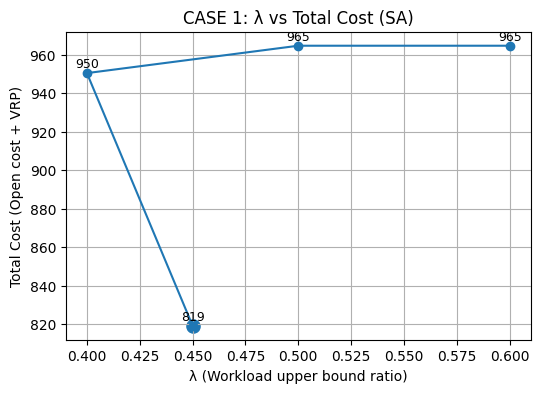

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import random

# =========================================================
# 1) λ별로 SA 여러 번 돌려서 최적해 찾는 함수
# =========================================================
def search_best_lambda(
    lambda_list,
    n_restarts=3,          # 각 λ마다 SA 몇 번 돌릴지
    T_init=800.0,
    T_min=1.0,
    alpha=0.9,
    iter_per_T=80
):
    results = []  # (lam, best_cost_for_lam, best_info_for_lam)

    for lam in lambda_list:
        best_cost_lam = float("inf")
        best_info_lam = None

        for r in range(n_restarts):
            random.seed(1000 + r)
            np.random.seed(2000 + r)

            _, _, cost, info = simulated_annealing_balance(
                lam=lam,
                T_init=T_init,
                T_min=T_min,
                alpha=alpha,
                iter_per_T=iter_per_T,
                verbose=False,
            )

            if cost < best_cost_lam:
                best_cost_lam = cost
                best_info_lam = info

        print(f"λ={lam:.3f} | best cost={best_cost_lam:.2f} | opened={best_info_lam['opened']}")
        results.append((lam, best_cost_lam, best_info_lam))

    # λ 중 최소 비용 찾기
    results.sort(key=lambda x: x[1])
    best_lambda, best_cost, best_info = results[0]

    print("\n===== λ 탐색 결과 =====")
    print("최적 λ :", best_lambda)
    print("최소 총비용 :", best_cost)
    print("개설된 DC :", best_info["opened"])
    print("=======================")

    return best_lambda, best_cost, best_info, results


# =========================================================
# 2) 실행 + λ–비용 그래프 시각화
# =========================================================
lambda_candidates = [0.40, 0.45, 0.50, 0.60]   # 공주님이 사용한 λ 리스트로 수정 가능

best_lambda, best_cost, best_info, results = search_best_lambda(
    lambda_list=lambda_candidates,
    n_restarts=5,     # 더 크게 하면 더 안정적 (시간↑)
    T_init=800.0,
    T_min=1.0,
    alpha=0.9,
    iter_per_T=80,
)

# 결과에서 λ와 비용만 뽑기
lams  = [r[0] for r in results]
costs = [r[1] for r in results]

# 최적 λ 위치
min_idx   = int(np.argmin(costs))
best_lam  = lams[min_idx]
best_cost = costs[min_idx]

# 그래프
plt.figure(figsize=(6,4))
plt.plot(lams, costs, marker="o")
plt.scatter([best_lam], [best_cost], s=90)  # 최적 점 표시

for x, y in zip(lams, costs):
    plt.text(x, y + 3, f"{y:.0f}", ha="center", fontsize=9)  # 각 점 위에 비용 숫자

plt.title("CASE 1: λ vs Total Cost (SA)")
plt.xlabel("λ (Workload upper bound ratio)")
plt.ylabel("Total Cost (Open cost + VRP)")
plt.grid(True)

print("\n★ CASE 1 최적 λ =", best_lam)
print("★ CASE 1 최소 총비용 =", best_cost)

plt.show()


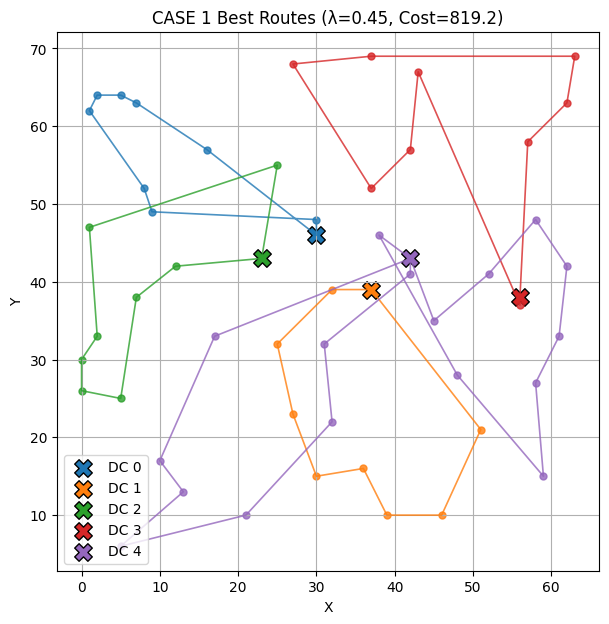

In [43]:
import matplotlib.pyplot as plt

# ------------------------------------------------------
# CASE 1 최적해(λ=best_lambda)의 VRP 경로를 한 그림에 시각화
#  - 전제: 아래 변수들이 이미 정의되어 있어야 함
#    - best_info  : search_best_lambda 에서 나온 최종 info
#    - dc_coords  : [(x,y), ...]  for each DC
#    - cust_coords: [(x,y), ...]  for each customer
# ------------------------------------------------------

opened_dcs    = best_info["opened"]
routes_detail = best_info["routes_detail"]

plt.figure(figsize=(7,7))

# DC별로 색 지정
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple",
          "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"]

# 1) DC 찍기
for idx, dc_id in enumerate(opened_dcs):
    x_dc, y_dc = dc_coords[dc_id]
    plt.scatter(x_dc, y_dc,
                marker="X", s=160,
                color=colors[idx % len(colors)],
                edgecolors="black",
                label=f"DC {dc_id}")

# 2) 고객 + 경로 그리기
for idx, dc_id in enumerate(opened_dcs):
    detail = routes_detail[dc_id]
    routes = detail["routes"]
    color  = colors[idx % len(colors)]

    for rt in routes:
        # 경로의 좌표 나열 (depot → 고객들 → depot)
        x_dc, y_dc = dc_coords[dc_id]
        xs = [x_dc]
        ys = [y_dc]
        for cid in rt:
            x_c, y_c = cust_coords[cid]
            xs.append(x_c)
            ys.append(y_c)
            # 고객 점도 같이 표시
            plt.scatter(x_c, y_c, s=25, color=color, alpha=0.8)
        xs.append(x_dc)
        ys.append(y_dc)

        # 선 그리기
        plt.plot(xs, ys, "-", linewidth=1.2, color=color, alpha=0.8)

plt.title(f"CASE 1 Best Routes (λ={best_lambda:.2f}, Cost={best_cost:.1f})")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# =========================================================
# 1) 데이터 로드
# =========================================================
customer = pd.read_csv("/content/Customer.csv").reset_index().rename(columns={"index": "Customer_ID"})
dc       = pd.read_csv("/content/DistributionCenter.csv").reset_index().rename(columns={"index": "DC_ID"})
truck    = pd.read_csv("/content/Truck.csv")

C = len(customer)   # 고객 수
D = len(dc)         # DC 수

TRUCK_CAPACITY = int(truck["CAPACITY"].iloc[0])   # 160
OPEN_COST      = float(dc["COST"].iloc[0])        # DC 하나 개설비 (동일하다고 가정)

demand        = customer["DEMAND"].values
total_demand  = demand.sum()

dc_coords   = [(dc.loc[j, "X"], dc.loc[j, "Y"]) for j in range(D)]
cust_coords = [(customer.loc[i, "X"], customer.loc[i, "Y"]) for i in range(C)]

# =========================================================
# 2) 유틸 함수: 거리, 라우트 생성
# =========================================================
def euclid(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def build_routes_for_dc(dc_id, ordered_customers):
    """
    ordered_customers : 이 DC에 배정된 고객 index 리스트 (순서 중요)
    → 용량 160 기준으로 여러 route로 나누고, depot-왕복 거리 계산
    """
    routes = []
    current_route = []
    current_load  = 0

    for cid in ordered_customers:
        d = demand[cid]
        if current_route and current_load + d > TRUCK_CAPACITY:
            routes.append(current_route)
            current_route = [cid]
            current_load  = d
        else:
            current_route.append(cid)
            current_load += d

    if current_route:
        routes.append(current_route)

    depot      = dc_coords[dc_id]
    total_dist = 0.0

    for rt in routes:
        prev = depot
        for cid in rt:
            cur = cust_coords[cid]
            total_dist += euclid(prev, cur)
            prev = cur
        total_dist += euclid(prev, depot)

    return routes, total_dist

# =========================================================
# 3) 결합 제약 (균형제약 + 최소고객제약)
# =========================================================
def is_feasible_combined(assign, lam, min_cust):
    """
    assign[i] = 고객 i가 배정된 DC (0~D-1)
    lam      : 균형 비율 λ
    min_cust : 최소 고객 수
    """
    dc_demands = np.zeros(D)
    counts     = np.zeros(D, dtype=int)

    for i in range(C):
        j = assign[i]
        dc_demands[j] += demand[i]
        counts[j]     += 1

    # (1) 균형 제약
    limit = lam * total_demand
    for j in range(D):
        if dc_demands[j] > limit:
            return False

    # (2) 최소고객 제약: 0 또는 ≥ MIN_CUST
    for j in range(D):
        if 0 < counts[j] < min_cust:
            return False

    return True

# =========================================================
# 4) repair 함수: 제약을 만족하도록 assignment 수정
# =========================================================
def repair_assign(assign, lam, min_cust, max_iter=5000):
    assign = assign[:]  # copy
    it = 0
    while not is_feasible_combined(assign, lam, min_cust) and it < max_iter:
        it += 1
        dc_demands = np.zeros(D)
        counts     = np.zeros(D, dtype=int)
        for i in range(C):
            j = assign[i]
            dc_demands[j] += demand[i]
            counts[j]     += 1

        limit = lam * total_demand

        # 1) 균형 제약 위반 DC 처리
        over_list = [j for j in range(D) if dc_demands[j] > limit]
        if over_list:
            j_bad = random.choice(over_list)
            cand_customers = [i for i in range(C) if assign[i] == j_bad]
            if not cand_customers:
                break
            i_move = random.choice(cand_customers)
            other_dcs = [j for j in range(D) if j != j_bad]
            if not other_dcs:
                break
            j_new = random.choice(other_dcs)
            assign[i_move] = j_new
            continue

        # 2) 최소고객 제약 위반 DC 처리 (0 < count < min_cust)
        small_list = [j for j in range(D) if 0 < counts[j] < min_cust]
        if small_list:
            j_bad = random.choice(small_list)
            cand_customers = [i for i in range(C) if assign[i] == j_bad]
            other_dcs = [j for j in range(D) if j != j_bad]
            if not cand_customers or not other_dcs:
                break
            for i_move in cand_customers:
                assign[i_move] = random.choice(other_dcs)
            continue

        # 더 이상 고칠 게 없으면 break
        break

    return assign

# =========================================================
# 5) GA용 초기 개체 생성
# =========================================================
def create_random_feasible_assign(lam, min_cust):
    # 1차: 가장 가까운 DC로 배정
    assign = [0] * C
    for i in range(C):
        dists = [euclid(cust_coords[i], dc_coords[j]) for j in range(D)]
        assign[i] = int(np.argmin(dists))

    # 조금 랜덤하게 섞기
    for _ in range(C):
        i = random.randint(0, C-1)
        assign[i] = random.randint(0, D-1)

    # repair로 제약 맞추기
    assign = repair_assign(assign, lam, min_cust)
    return assign

# =========================================================
# 6) fitness 함수 (비용 계산)
# =========================================================
BIG_COST = 1e18

def compute_cost_ga(assign, lam, min_cust, return_detail=False):
    """
    return_detail=True면 route 정보 같이 반환 (최적해 시각화용)
    """
    if not is_feasible_combined(assign, lam, min_cust):
        if return_detail:
            return BIG_COST, {"feasible": False}
        else:
            return BIG_COST

    opened         = []
    total_vrp_cost = 0.0
    routes_detail  = {}

    for j in range(D):
        # 이 DC에 배정된 고객들
        assigned_customers = [i for i in range(C) if assign[i] == j]
        if len(assigned_customers) == 0:
            continue

        opened.append(j)

        # 경로 순서: DC 기준 polar angle로 정렬 (간단한 휴리스틱)
        dc_x, dc_y = dc_coords[j]
        def angle(cid):
            x, y = cust_coords[cid]
            return np.arctan2(y - dc_y, x - dc_x)

        ordered = sorted(assigned_customers, key=angle)
        routes, dist = build_routes_for_dc(j, ordered)
        total_vrp_cost += dist

        routes_detail[j] = {
            "routes":            routes,
            "ordered_customers": ordered,
            "distance":          dist
        }

    open_cost  = len(opened) * OPEN_COST
    total_cost = open_cost + total_vrp_cost

    if return_detail:
        info = {
            "feasible":      True,
            "opened":        opened,
            "open_cost":     open_cost,
            "vrp_cost":      total_vrp_cost,
            "routes_detail": routes_detail
        }
        return total_cost, info
    else:
        return total_cost

# =========================================================
# 7) GA 연산자 (선택 / 교차 / 돌연변이)
# =========================================================
def tournament_select(pop, costs, k=3):
    """비용이 작은 개체가 이기는 tournament selection."""
    idxs = random.sample(range(len(pop)), k)
    best_idx = min(idxs, key=lambda idx: costs[idx])
    return pop[best_idx][:]  # copy

def crossover(parent1, parent2, lam, min_cust, p_crossover=0.9):
    if random.random() > p_crossover:
        return parent1[:]

    child = parent1[:]
    for i in range(C):
        if random.random() < 0.5:
            child[i] = parent2[i]

    # 교차 후 repair
    child = repair_assign(child, lam, min_cust)
    return child

def mutate(assign, lam, min_cust, p_mut=0.1):
    child = assign[:]
    for i in range(C):
        if random.random() < p_mut:
            child[i] = random.randint(0, D-1)
    child = repair_assign(child, lam, min_cust)
    return child

# =========================================================
# 8) GA 메인 루프
# =========================================================
def run_ga(
    lam,
    min_cust,
    pop_size=50,
    n_gen=200,
    p_crossover=0.9,
    p_mut=0.1,
    elitism=2,
    verbose=True
):
    # 초기 population 생성
    population = [create_random_feasible_assign(lam, min_cust) for _ in range(pop_size)]
    costs      = [compute_cost_ga(ind, lam, min_cust) for ind in population]

    best_idx   = int(np.argmin(costs))
    best_ind   = population[best_idx][:]
    best_cost  = costs[best_idx]

    if verbose:
        print(f"[초기] best cost = {best_cost:.2f}")

    for g in range(n_gen):
        new_pop   = []
        new_costs = []

        # elitism: 현재 best 개체 몇 개 복사
        elite_idx = np.argsort(costs)[:elitism]
        for idx in elite_idx:
            new_pop.append(population[idx][:])
            new_costs.append(costs[idx])

        # 나머지 population 채우기
        while len(new_pop) < pop_size:
            p1 = tournament_select(population, costs, k=3)
            p2 = tournament_select(population, costs, k=3)
            child = crossover(p1, p2, lam, min_cust, p_crossover=p_crossover)
            child = mutate(child, lam, min_cust, p_mut=p_mut)

            new_pop.append(child)
            new_costs.append(compute_cost_ga(child, lam, min_cust))

        population = new_pop
        costs      = new_costs

        cur_best_idx  = int(np.argmin(costs))
        cur_best_cost = costs[cur_best_idx]

        if cur_best_cost < best_cost:
            best_cost = cur_best_cost
            best_ind  = population[cur_best_idx][:]

        if verbose and (g % 10 == 0 or g == n_gen-1):
            print(f"Gen {g:4d} | current best = {cur_best_cost:.2f} | global best = {best_cost:.2f}")

    # 최종 best 해에 대해 상세 정보 계산
    final_cost, final_info = compute_cost_ga(best_ind, lam, min_cust, return_detail=True)
    return best_ind, final_cost, final_info

# =========================================================
# 9) 실행 + VRP 경로 한 번에 시각화
# =========================================================
# 공주님이 원하는 λ, MIN_CUST 설정 (필요에 따라 수정)
lam      = 0.45   # 예: CASE 1에서 좋았던 λ
min_cust = 20     # 예: MIN_CUST 후보 중 선택값

random.seed(0)
np.random.seed(0)

best_assign, best_cost, best_info = run_ga(
    lam=lam,
    min_cust=min_cust,
    pop_size=60,
    n_gen=200,
    p_crossover=0.9,
    p_mut=0.15,
    elitism=3,
    verbose=True
)

print("\n========== GA 최종 결과 ==========")
print(f"λ = {lam}, MIN_CUST = {min_cust}")
print("최소 총비용:", best_cost)
print("개설된 DC:", best_info["opened"])
print("개설비용:", best_info["open_cost"])
print("VRP 비용:", best_info["vrp_cost"])
print("==================================")

# ---- 최적 해 VRP 경로 전체 시각화 (모든 DC를 한 그림에) ----
opened_dcs    = best_info["opened"]
routes_detail = best_info["routes_detail"]

plt.figure(figsize=(7,7))

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple",
          "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"]

# DC 표시
for idx, dc_id in enumerate(opened_dcs):
    x_dc, y_dc = dc_coords[dc_id]
    plt.scatter(x_dc, y_dc,
                marker="X", s=180,
                color=colors[idx % len(colors)],
                edgecolors="black",
                label=f"DC {dc_id}")

# 고객 + 경로 표시
for idx, dc_id in enumerate(opened_dcs):
    detail = routes_detail[dc_id]
    routes = detail["routes"]
    color  = colors[idx % len(colors)]

    for rt in routes:
        # 경로의 좌표 (depot → 고객들 → depot)
        x_dc, y_dc = dc_coords[dc_id]
        xs = [x_dc]
        ys = [y_dc]
        for cid in rt:
            x_c, y_c = cust_coords[cid]
            xs.append(x_c)
            ys.append(y_c)
            plt.scatter(x_c, y_c, s=25, color=color, alpha=0.8)
        xs.append(x_dc)
        ys.append(y_dc)
        plt.plot(xs, ys, "-", linewidth=1.2, color=color, alpha=0.8)

plt.title(f"GA Best Routes (λ={lam}, MIN_CUST={min_cust}, Cost={best_cost:.1f})")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.legend()
plt.show()


[초기] best cost = 1000000000000000000.00
Gen    0 | current best = 1000000000000000000.00 | global best = 1000000000000000000.00
Gen   10 | current best = 1000000000000000000.00 | global best = 1000000000000000000.00
Gen   20 | current best = 1000000000000000000.00 | global best = 1000000000000000000.00
Gen   30 | current best = 1000000000000000000.00 | global best = 1000000000000000000.00
Gen   40 | current best = 1000000000000000000.00 | global best = 1000000000000000000.00
Gen   50 | current best = 1000000000000000000.00 | global best = 1000000000000000000.00
Gen   60 | current best = 1000000000000000000.00 | global best = 1000000000000000000.00
